In [4]:
import gym_causal
import numpy as np
import matplotlib.pyplot as plt
import gym
import networkx as nx
import random
import scipy.special as spc

In [5]:
class Agent(object):
    """
    Causal Agent
    """
    def __init__(self, act_space, obs_space, rew_space):
        
        self.action_space = act_space
        self.observation_space = obs_space
        self.reward_space = rew_space
        self.time = 0
        self.occ_table = np.zeros([len(rew_space),
                           len(self.action_space),
                           len(self.observation_space)])
        self.G = self.create_graph()
        self.memory = np.zeros((1, 4))
        
    def create_graph(self):
        """
        Init the causal graph
        
        """
        
        G = nx.DiGraph()
        
        for i in range(len(self.observation_space)):
            node_name = "obs" + str(i)
            G.add_node(node_name)
        for i in range(len(self.action_space)):
            node_name = "act" + str(i)
            G.add_node(node_name)
        for i in range(len(self.reward_space)):
            node_name = "rew" + str(i)
            G.add_node(node_name)
            
        return G

    def act(self, temp):
        
        if (self.time == 0):
            action = random.choice(self.action_space)
        else:
            probs = np.exp(agent.occ_table[1:].sum(axis=0)/temp) / np.sum(np.exp(agent.occ_table[1:].sum(axis=0)/temp))
            cumul = 0
            choice = random.uniform(0, 1)
            for a, pr in enumerate(probs[:, 1]):
                cumul += pr
                if cumul > choice:
                    action = a  
                else: 
                    action = random.choice(self.action_space)                  
        self.time += 1

        return action
    

        
    def update_memory(self, act, obs, rew, done):
        
        self.memory = np.append(self.memory, np.array([[act, obs, rew, done]]), axis = 0)   

        # first get the nodes corresponding to last action/ob/rew
        action_node = "act" + str(np.where(act == self.action_space)[0][0])
        obs_node = "obs" + str(np.where(obs == self.observation_space)[0][0])
        rew_node = "rew" + str(np.where(rew == self.reward_space)[0][0])
        
        # check if the edges already exist to update the weights
        if ((action_node, obs_node) in self.G.edges):
            act_obs_weight = self.G[action_node][obs_node]['weight']
        else: 
             act_obs_weight = 1
        
        if ((action_node, rew_node) in self.G.edges):
            act_rew_weight = self.G[action_node][rew_node]['weight']
        else:
            act_rew_weight = 1
        
        if ((obs_node, rew_node) in self.G.edges):
            obs_rew_weight = self.G[obs_node][rew_node]['weight']
        else:
            obs_rew_weight = 1
            
        # then draw edges from action to (obs and rew) nodes
        self.G.add_edge(action_node, obs_node, weight = act_obs_weight + 1)
        self.G.add_edge(action_node, rew_node, weight = act_rew_weight + 1)
        self.G.add_edge(obs_node, rew_node, weight = obs_rew_weight + 1)
        
        # update co occurence table 
        i = (np.where(rew == self.reward_space)[0][0])
        j = (np.where(act == self.action_space)[0][0])
        k = (np.where(obs == self.observation_space)[0][0])
        self.occ_table[i][j][k] += 1
        

class randomAgent(object):
    """
    Random agent
    """
    def __init__(self,
                 action_space,
                 observation_space,
                 reward_space):
        
        self.action_space = action_space
        self.observation_space = observation_space
        self.reward_space = reward_space
        self.time = 0

        
    def act(self):
    
        action = random.choice(self.action_space)    
        self.time += 1
       
        return action
    

The following code is intended for the specific Volleyball task

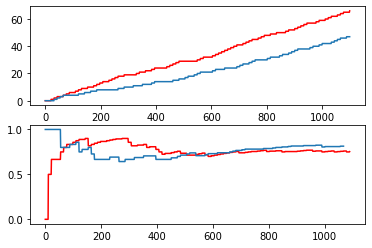

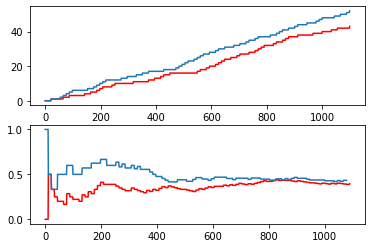

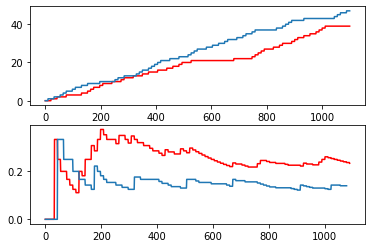

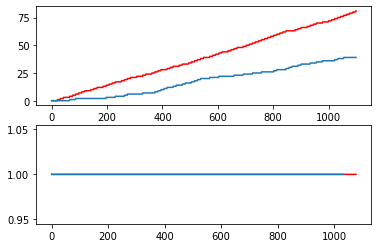

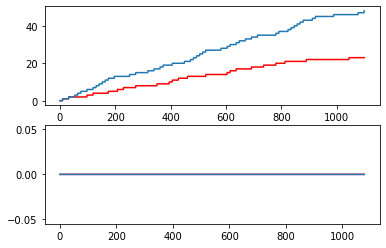

In [50]:
# PARAMETERS
different_probs = np.array([[0.8, 0.2],
                            [0.5, 0.5],
                            [0.2, 0.8], 
                            [1, 0], 
                            [0, 1]])
list_rewards = []
episode_count = 100 # total number of game is episode_count*10 or 11?
# for the plot
x = np.arange(1, episode_count*11, 1)

for j in range(len(different_probs)):
    # INIT PARAMETERS
    probs1, probs2 = different_probs[j]
    reward = 0
    done = False
    temp = 1000000
    #INIT ENV
    env = gym.make('gym_causal:causal-v0')
    env.reset()
    env.set_probs(probs1, probs2)
    env.set_rewards(np.array([0, 1]))
    
    #CREATE AGENT
    agent = Agent(env.action_space,
                  env.observation_space, 
                  env.reward_space)
    
    # INIT REWARD RECORD
    rewards = np.zeros(episode_count*11)
    total_reward = 0
    
    #random agent
    randenv = gym.make('gym_causal:causal-v0')
    randenv.reset()
    randenv.set_probs(probs1, probs2)
    randenv.set_rewards(np.array([0, 1]))
    
    randag = randomAgent(env.action_space,
                  env.observation_space, 
                  env.reward_space)
    randrewards = np.zeros(episode_count*11)
    randtotal_reward = 0

    j = 0
    l = 0
    plays = 0
    winsplays = 0
    p_win_play = []
    
    plays1 = 0
    winsplays1 = 0
    p_win_play1 = []
    for i in range(1, episode_count+1):
        # RESET BEFORE EPISODE
        env.reset()
        randenv.reset()
        done = False

        while not done: 
            # Causal agent
            temp *= 0.99

            action = agent.act(temp)
            ob, reward, done, _ = env.step(action)
            if (action == 1) and done:
                plays += 1
                if (reward == 1):
                    winsplays += 1
            if (plays != 0):
                p_win_play.append(winsplays/plays)
            # update agent memory & causal graph
            agent.update_memory(action, ob, reward, done)
            
            total_reward += reward
            rewards[j] = total_reward

            j += 1
            
            
        done = False
        while not done: 
            # random agent
            action = randag.act()
            #print("action", action)
            ob, reward, done, _ = randenv.step(action)
            #print("reward", reward)
            #print(randenv.time)
            if (action == 1) and done:
                plays1 += 1
                if (reward == 1):
                    winsplays1 += 1
            if (plays1 != 0):
                p_win_play1.append(winsplays1/plays1)
            randtotal_reward += reward
            #print(randtotal_reward)
            randrewards[l] = randtotal_reward

            l += 1
   
    fig, axs  = plt.subplots(2)
    list_rewards.append(rewards)
    x = np.arange(0, len(rewards), 1)
    axs[0].plot(x, rewards, color='r')
    axs[0].plot(x, randrewards)
    x = np.arange(0, len(p_win_play), 1)
    x1 = np.arange(0, len(p_win_play1), 1)
    axs[1].plot(x, p_win_play, 'r')
    axs[1].plot(x1, p_win_play1)
    env.close()
    randenv.close()

In [155]:
def get_data_for_plot_agent(different_probs):
    # PARAMETERS
    list_rewards = []
    episode_count = 100 # total number of game is episode_count*10 or 11?
    # for the plot
    x = np.arange(0, episode_count*11, 1)

    for j in range(len(different_probs)):
        # INIT PARAMETERS
        probs1, probs2 = different_probs[j]
        reward = 0
        done = False
        temp = 1000000
        #INIT ENV
        env = gym.make('gym_causal:causal-v0')
        env.reset()
        env.set_probs(probs1, probs2)
        env.set_rewards(np.array([0, 1]))

        #CREATE AGENT
        agent = Agent(env.action_space,
                      env.observation_space,
                      env.reward_space)

        # INIT REWARD RECORD
        rewards = np.zeros(episode_count*11)
        total_reward = 0

        #random agent
        randenv = gym.make('gym_causal:causal-v0')
        randenv.reset()
        randenv.set_probs(probs1, probs2)
        randenv.set_rewards(np.array([0, 1]))

        randag = randomAgent(env.action_space,
                      env.observation_space,
                      env.reward_space)
        randrewards = np.zeros(episode_count*11)
        randtotal_reward = 0

        j = 0
        l = 0
        
        plays = 0
        winsplays = 0
        p_win_play = np.zeros(episode_count*11)

        plays1 = 0
        winsplays1 = 0
        p_win_play1 = []
        for i in range(0, episode_count):
            # RESET BEFORE EPISODE
            env.reset()
            randenv.reset()
            done = False
            while not done:
                # Causal agent
                temp *= 0.99
                action = agent.act(temp)
                ob, reward, done, _ = env.step(action)
                if (action == 1) and done:
                    plays += 1
                    if (reward == 1):
                        winsplays += 1
                if (plays != 0):
                    p_win_play[i] =  winsplays/plays
                # update agent memory & causal graph
                agent.update_memory(action, ob, reward, done)

                total_reward += reward
                rewards[j] = total_reward

                j += 1
            

            done = False
            while not done:
                # random agent
                action = randag.act()
                #print("action", action)
                ob, reward, done, _ = randenv.step(action)
                #print("reward", reward)
                #print(randenv.time)
                if (action == 1) and done:
                    plays1 += 1
                    if (reward == 1):
                        winsplays1 += 1
                if (plays1 != 0):
                    p_win_play1.append(winsplays1/plays1)
                randtotal_reward += reward
                #print(randtotal_reward)
                randrewards[l] = randtotal_reward

                l += 1

        list_rewards.append(rewards)
        env.close()
        randenv.close()
        return p_win_play


In [156]:
p, q = get_data_for_plot(np.array([[0.8, 0.2]]))

In [157]:
p = [get_data_for_plot_agent(np.array([[0.8,0.2]])) for i in range(10)]
p = np.stack(p, axis=0)

In [158]:
p.shape

(10, 1100)

In [164]:
np.std(p[:, 0])

0.4898979485566356

In [165]:
means = np.zeros(1100)
std = np.zeros(1100)
for j in range(1100):
    means[j] = np.mean(p[:,j])
    std[j] = np.std(p[:, j])
    

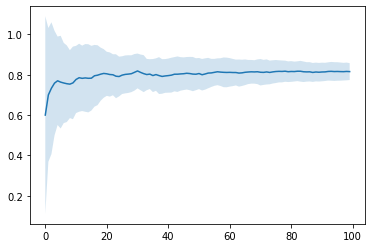

In [171]:
x = np.arange(1100)
plt.plot(x[:100], means[:100])
plt.fill_between(x[:100], means[:100] - std[:100], means[:100] + std[:100], alpha=0.2)